# teste 

In [1]:
# imports 
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import tensorflow as tf
from collections import Counter
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
import shutil

In [60]:
# Import model
from tensorflow.keras.models import load_model
# Load the model
cnn_model = load_model("Modelos/alzheimers_detection_model_FJSL_V4.h5")

In [71]:
# Define Paths
dataset_dir = "test_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 750
Class: Moderate Dementia, Files Found: 73
Class: Non Demented, Files Found: 2250
Class: Very mild Dementia, Files Found: 2059


In [72]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read the image from the path
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image to RGB
    image = tf.image.resize(image, [128, 128])  # Resize to (128, 128)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load and preprocess a list of images
def load_and_preprocess_images(image_paths):
    # Preprocess all images and store them in a list
    images = [preprocess_image(image_path) for image_path in image_paths]
    
    # Stack the images into a single batch (shape: (batch_size, 128, 128, 3))
    images_batch = tf.stack(images)
    
    return images_batch


test_data = load_and_preprocess_images(image_paths)

# Convert labels to NumPy array
#labels = np.array(labels)


161/161 [==============================] - 6s 37ms/step
[0 3 0 ... 3 3 3]
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.86      0.87      0.86       750
 Moderate Dementia       0.87      0.89      0.88        73
      Non Demented       0.97      0.80      0.88      2250
Very mild Dementia       0.82      0.96      0.88      2059

          accuracy                           0.88      5132
         macro avg       0.88      0.88      0.88      5132
      weighted avg       0.89      0.88      0.88      5132



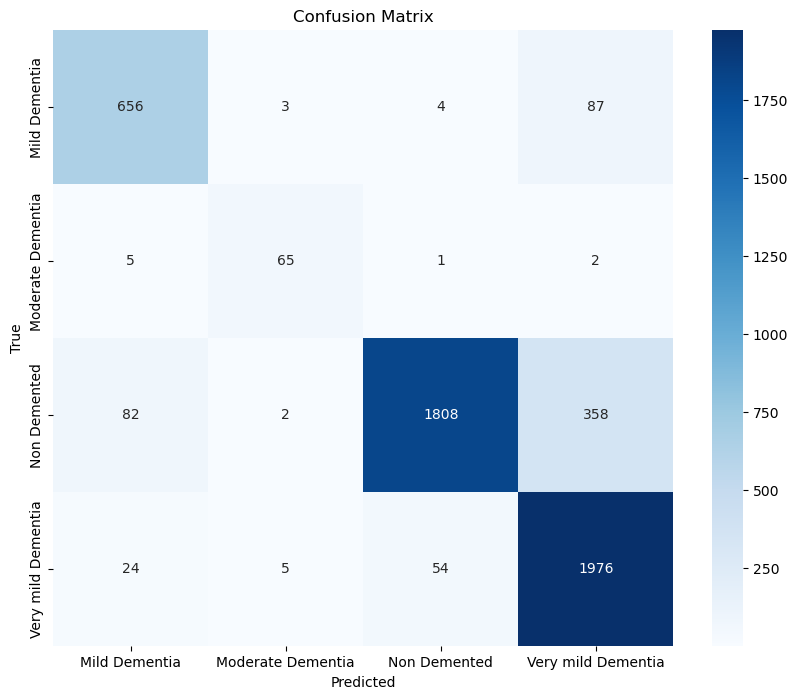

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

y_true = labels
predictions = cnn_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
# Classification Report
class_names = classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_performance(model, val_ds, class_names, model_name="Model"):
    """
    Evaluate a trained model and show confusion matrix, accuracy, and classification report.

    Parameters:
        model (tf.keras.Model): Trained model to evaluate.
        val_ds (tf.data.Dataset): Validation dataset (batched).
        class_names (list): List of class names.
        model_name (str): Optional label for the plots and title.
    """
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # Classification report
    print(f"📊 {model_name} - Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ {model_name} - Validation Accuracy: {acc:.4f}")

In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
import matplotlib.pyplot as plt

def evaluate_single_image(model, image_path, class_names, model_name="Model", target_size=(224, 224)):
    """
    Predict a single image using a trained model and display the result.

    Parameters:
        model (tf.keras.Model): Trained model.
        image_path (str): Path to the image file.
        class_names (list): List of class names.
        model_name (str): Optional name for labeling output.
        target_size (tuple): Target size for image resizing.
    """
    # Load and preprocess the image
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension
    img_array = tf.image.resize(img_array, [128, 128])  # Resize to (128, 128)
    img_array = img_array / 255.0  # Normalize if your model expects this
  

    # Predict
    preds = model.predict(img_array)
    print(preds)
    pred_class_index = np.argmax(preds[0])
    pred_class_name = class_names[pred_class_index]
    confidence = preds[0][pred_class_index]

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{model_name} Prediction:\n{pred_class_name} ({confidence:.2%})")
    plt.show()

    print(f"🔍 {model_name} - Predicted class: {pred_class_name} (Confidence: {confidence:.2%})")


1/1 [==============================] - 0s 15ms/step
[[0.03873253 0.80921924 0.09935064 0.05269761]]


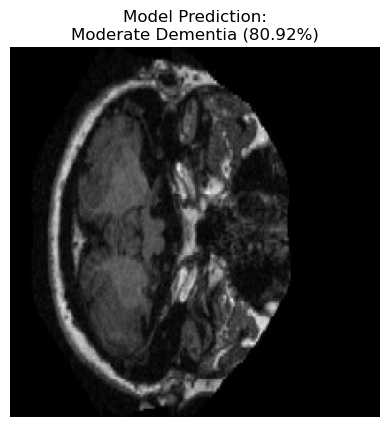

🔍 Model - Predicted class: Moderate Dementia (Confidence: 80.92%)


In [83]:
evaluate_single_image(cnn_model, "Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_105.jpg", class_names=classes)
